
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [18]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-yrtrqv79
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-yrtrqv79


## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

The clusters I construct below are not particularly insightful for my analysis of the issue at hand. What I had in mind was to take a subset of a csv dataset of all speeches given in the German parliament and see if the variable 'factionID', namely party identity, is valid variable to use for clustering the text. 

While I was able to create clusters and interrogate them, I realized that in order to properly analyze this data, I would have to clean the data much more beforehand. For instance, I would have to conduct an analysis of the most common words in the dataset that are used across all parties (e.g. words like "Mr. Speaker", "Colleague", "Mister" and "Misses" -- words members of parliament use to refer to one another). Still, I found this exercise to be useful in understanding not only how to construct these clusters, but also how to think about them and my dataset in a way that is productive in terms of my research.

Note: For simplicity reasons, I simply adopted the many of the same variable names that were given to us. If I was to conduct a formal analysis of the data (e.g. for my MA thesis), I would of course assign them names that make sense in terms of my dataset.

In [19]:
#mounting drive
from google.colab import drive
drive.mount("/content/drive")
#importing csv file and converting into dataframe
og_df = pandas.read_csv('/content/drive/MyDrive/csv/speeches.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#converting date variable to datetime format
og_df['date'] = pandas.to_datetime(og_df['date'])
type(og_df['date'])
#extract shorter subset of the dataset -- from German reunification until the end of Kohl's final term as Chancellor
#for now, i will just choose one year. later I'm hoping to utilize a large subset
mask = (og_df['date'] > '1997-10-03') & (og_df['date'] <= '1998-10-26')
smalldf = og_df.loc[mask]
#remove irrelevant columns
real_df = smalldf[['speechContent', 'factionId']]
add_df = smalldf['factionId']
df = real_df['speechContent']

In [21]:
import nltk
nltk.download('stopwords')
german_stop_words = stopwords.words('german')
german_stop_words = german_stop_words.append(['herr', 'präsident'])
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words=german_stop_words, norm='l2')
print(german_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
None


In [22]:
#initialize
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(df)

newsgroupsVects[:10,:20].toarray()
# TFIDF
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

#initialize
import nltk
nltk.download('stopwords')
german_stop_words = stopwords.words('german')
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words=german_stop_words, norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(df)

try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:100]))

(11584, 99584)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
vector is missing
The available words are: ['herr', 'präsident', 'liebe', 'kolleginnen', 'kollegen', 'kollege', 'deutlich', 'nämlich', 'eigentlich', 'gar', 'thema', 'damen', 'herren', 'koalition', 'sogenannten', 'besondere', 'dabei', 'ergebnis', 'entscheidungen', 'jedoch', 'sollen', 'rahmen', 'grundlage', 'bevölkerung', 'teil', 'öffentlichen', 'verfahren', 'deshalb', 'frage', 'warum', 'diskussion', 'abs', 'steht', 'heute', 'darf', 'grund', 'anlage', 'erforderlich', 'wichtigen', 'erfolg', 'möchte', 'muß', 'getroffen', 'gehalten', 'läßt', 'geht', 'wissenschaft', 'geworden', 'angenommen', 'kommen', 'denen', 'wäre', '10', '000', 'sogar', '100', 'müßten', 'bundesrepublik', 'bürgerinnen', 'hätte', 'gestellt', 'derzeit', 'gilt', 'müßte', 'folgen', 'kommt', 'aufbau', 'trotzdem', 'bekommen', 'öffentlichkeit', 'gibt', 'weiteren', 'beteiligung', 'natürlich', 'debat

In [23]:
#Clusters!
numClusters = len(set(add_df))
numClusters
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsgroupsTFVects)
#evaluate the clusters
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(add_df, km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(add_df, km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(add_df, km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(add_df, km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'DistanceMetric', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'd2_tweedie_score', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_gamma_deviance', 'mean_pinball_loss', 'me

In [24]:
#interrogate alignment between specific speeches and their cluster:
df['kmeans_predictions'] = km.labels_
df
#look at distinguishing terms in each cluster
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
#these don't tell us much yet because a lot of these words are formalities I have to remove. will get back to this later

Top terms per cluster:
Cluster 0:
 bitte
 schön
 herr
 ja
 frau
 kollege
 zeit
 kollegin
 abgeordneter
 dr


Cluster 1:
 13
 drucksache
 beschlußempfehlung
 beratung
 stimmen
 ausschuß
 fraktion
 aussprache
 dr
 90


Cluster 2:
 zwischenfrage
 gestatten
 herr
 kollegen
 abgeordneten
 kollege
 kollegin
 abgeordneter
 minister
 frau


Cluster 3:
 zusatzfrage
 bitte
 zweite
 weitere
 schön
 herr
 abgeordneter
 frau
 kollege
 erste


Cluster 4:
 wort
 abgeordnete
 abgeordneten
 gebe
 dr
 kollege
 kurzintervention
 fraktion
 kollegin
 csu


Cluster 5:
 herr
 kollege
 frage
 ja
 bundesregierung
 frau
 staatssekretär
 kollegin
 redezeit
 fragen


Cluster 6:
 mehr
 muß
 müssen
 herr
 heute
 sagen
 deutschland
 immer
 dm
 herren




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


In [25]:
#modify add_df in order for it to not contain any negative values (and subsequently not mess with the colors in graphs)
add_df_2 = add_df + 2
add_df_2[:20]
pandas.unique(add_df_2)

array([24,  5,  1,  6, 25, 15, 18])

In [26]:
#visualize the clusters
#perform principle components analysis to reduce dimensionality of the data
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())
#do a biplot
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]
#build a map of colors for true labels
colordict = {
'24': 'red',
'5': 'orange',
'1': 'green',
'6': 'blue',
'25': 'black',
'15': 'pink',
'18': 'cyan'
    }
colors = [colordict[str(c)] for c in add_df_2]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('24', 'red'), ('5', 'orange'), ('1', 'green'), ('6', 'blue'), ('25', 'black'), ('15', 'pink'), ('18', 'cyan')])


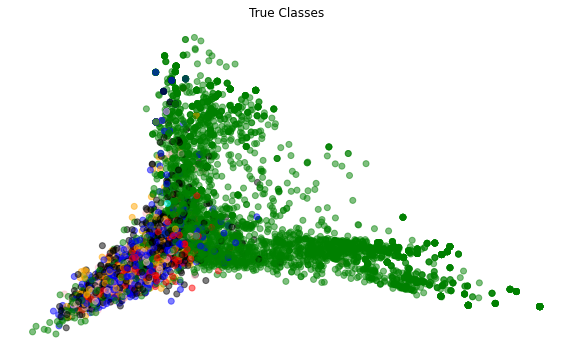

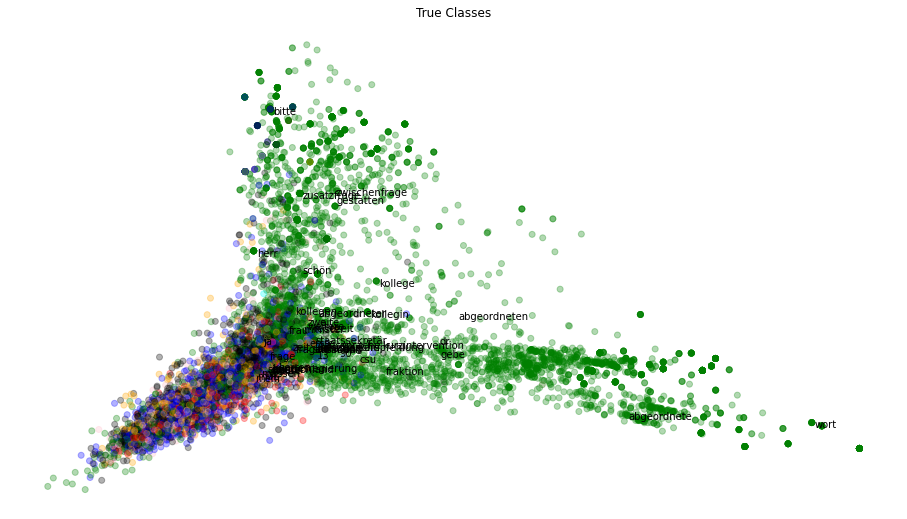

In [27]:
#create a plot
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()
#create a biplot and map vector on the same space
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [28]:
#Silhouette Analysis -- Identifying "optimal" cluster number
#first, define the helper function
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


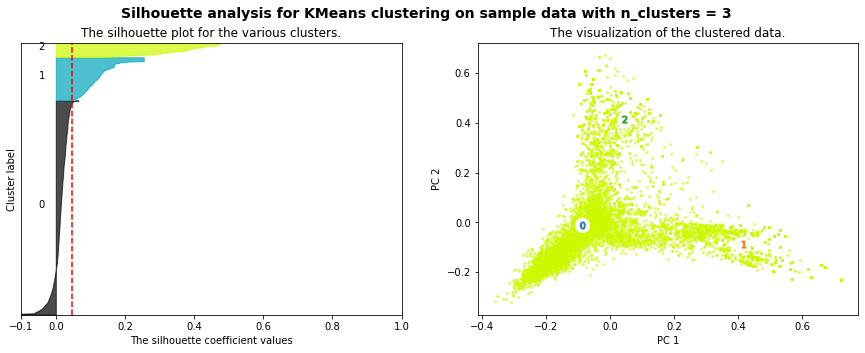

For n_clusters = 3, The average silhouette_score is : 0.048


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


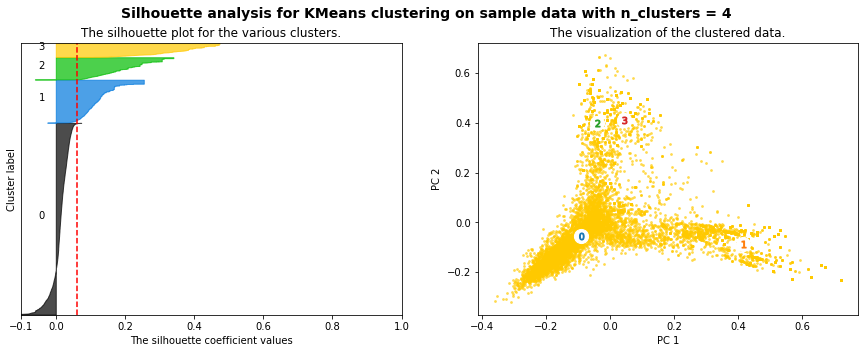

For n_clusters = 4, The average silhouette_score is : 0.062


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


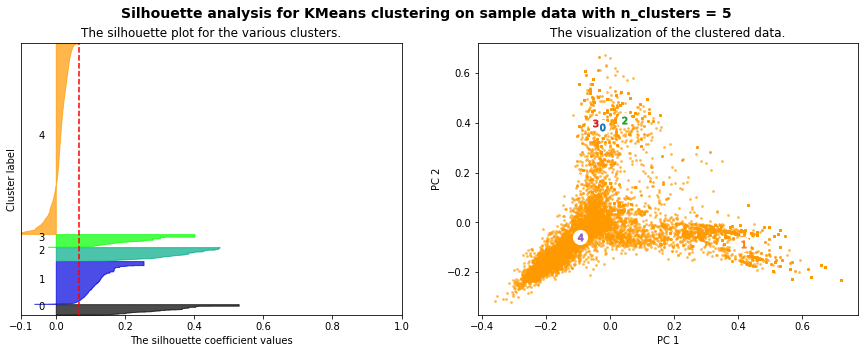

For n_clusters = 5, The average silhouette_score is : 0.068


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


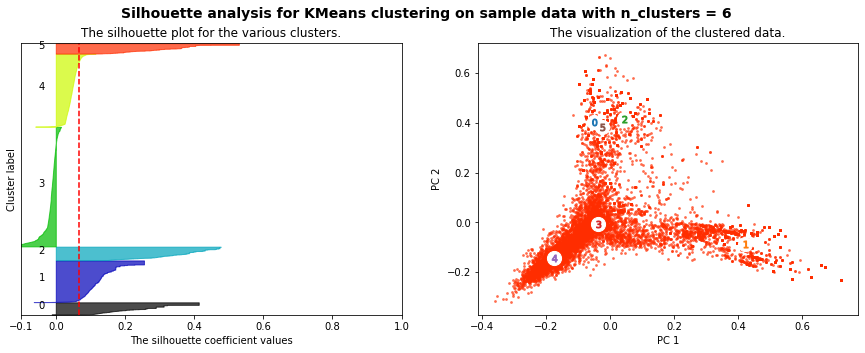

For n_clusters = 6, The average silhouette_score is : 0.068


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


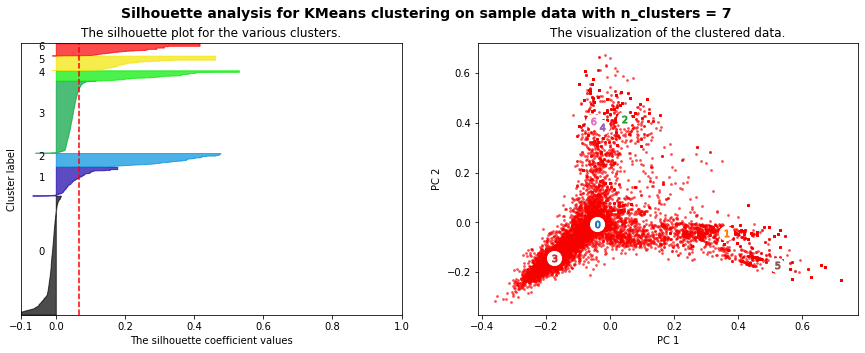

For n_clusters = 7, The average silhouette_score is : 0.067


In [29]:
#examine different number of clusters
#3 clusters
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)
#4 clusters
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)
#5 clusters
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)
#6 clusters
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)
#7 clusters
X = newsgroupsTFVects.toarray()
plotSilhouette(7, X)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [30]:
#creating smaller subset of data to avoid "index out of range" error
smalldf2 = og_df.loc[mask]
#remove irrelevant columns
real_df2 = smalldf2[['speechContent', 'factionId']]
add_df2 = smalldf2['factionId']
df2 = real_df2['speechContent']
df2 = df2.reset_index()
real_df2 = real_df2.reset_index()

In [31]:
#hierarchical clustering of documents using two approaches and tree visualizations
newsgroupsTFVects
newsgroupsTFVects[:100].todense()
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
newsgroupsCoocMat.setdiag(0)
#compute a tree of nested clusters
selectIndices = []
indexToCat = []
for c in set(real_df2['factionId']):
    selectIndices += list(real_df2[real_df2['factionId'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('factionId').sum()
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[2.20000000e+01, 3.14000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.30000000e+02, 3.17000000e+02, 2.85818212e-01, 3.00000000e+00],
       [2.10000000e+01, 3.18000000e+02, 4.68058906e-01, 4.00000000e+00],
       [1.91000000e+02, 3.19000000e+02, 4.87602433e-01, 5.00000000e+00],
       [2.70000000e+02, 3.20000000e+02, 6.37970093e-01, 6.00000000e+00],
       [1.25000000e+02, 2.26000000e+02, 6.73809027e-01, 2.00000000e+00],
       [1.58000000e+02, 2.04000000e+02, 6.89117736e-01, 2.00000000e+00],
       [5.40000000e+01, 1.59000000e+02, 6.96669645e-01, 2.00000000e+00],
       [3.70000000e+01, 1.65000000e+02, 7.01088837e-01, 2.00000000e+00],
       [1.80000000e+01, 3.22000000e+02, 7.13323399e-01, 3.00000000e+00]])

In [32]:
#visualize the tree
#commenting out the below code because it took forever to run and didn't produce meaningful results.
#dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)
#dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)
#hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
#hierarchicalClusters
#linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
#hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
#print("For our complete clusters:")
#print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(real_df2['factionID'], hierarchicalClusters_full)))
#print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(real_df2['factionID'], hierarchicalClusters_full)))
#print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(real_df2['factionID'], hierarchicalClusters_full)))
#print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(real_df2['factionID'], hierarchicalClusters_full)))
#real_df2['wald_predictions'] = hierarchicalClusters_full
#real_df2

I think it makes sense to jointly interpret the results of exercises 2 and 3, so please refer to my interpretation below.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font> 

In [17]:
#begin with LDA topic modeling, later blocks: hierarchical dirichlet process!
#rename columns
real_df['name'] = real_df['factionId']
real_df['text'] = real_df['speechContent']
#tokenize and normalize
senReleasesTraining = real_df
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [33]:
#new vectorizer
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words=german_stop_words, norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))
#define dictionary
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])
#create list of tuples
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]
#serialize corpus as file and load it
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [34]:
senReleasesTraining['reduced_tokens'][574633]

['türk',
 'uldall',
 'abm',
 'steinkohle',
 'sinnvoller',
 'kabinett',
 'beschlossene',
 'abm',
 'rüstungsindustrie',
 'steinkohle',
 'eurofighter',
 'atomgesetzes',
 'vorschlagen',
 'atomgesetz',
 'einfügen',
 'französische',
 'epr',
 'standortunabhängigen',
 'prüfverfahren',
 'unterzogen',
 'öffentlichkeitsbeteiligung',
 'stadium',
 'standortunabhängigen',
 'präjudiz',
 'landesbehörden',
 'späteren',
 'genehmigungsverfahren',
 'inhalte',
 'abgeschlossenen',
 'prüfverfahrens',
 'be',
 'späteren',
 'genehmigungsverfahrens',
 'information',
 'bekanntgabe',
 'ergebnisses',
 'be',
 'bundesanzeiger',
 'prüfergebnis',
 'be',
 'sicherheitsbericht',
 'bekanntgabe',
 'vorhabens',
 'beschränkt',
 'aussagefähig',
 'unwillkürlich',
 'drängt',
 'tatsachen',
 'atomgesetzes',
 'atomkraftwerk',
 'genehmigung',
 'erteilt',
 'beschaffenheit',
 'betriebs',
 'katastrophenschutzmaßnahmen',
 'abgeschlossenen',
 'geländes',
 'aufnahme',
 'bestimmung',
 'atomgesetz',
 'anti',
 'atom',
 'bewegung',
 'bestimmu

In [35]:
#inspect degree to which distinct texts load on topics
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][574633])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][574633]))
print("are: {}".format(sen1lda))
#which topics does our model predict?
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })
#make each topic its own column
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

The topics of the text: 22
are: [(5, 0.35957927), (9, 0.626941)]


,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
574669,22,"[(2, 0.9932292)]",0.000000,0.000000,0.993229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
575579,3,"[(0, 0.01576221), (1, 0.48305154), (2, 0.02752...",0.015762,0.483052,0.027525,0.014820,0.168624,0.014307,0.229873,0.015274,0.014687,0.016076
575679,-1,"[(0, 0.56352615), (1, 0.011708346), (2, 0.0650...",0.563526,0.011708,0.065063,0.013021,0.275972,0.012568,0.017698,0.013422,0.012897,0.014125
575779,3,"[(2, 0.48836195), (5, 0.102034025), (6, 0.4021...",0.000000,0.000000,0.488362,0.000000,0.000000,0.102034,0.402173,0.000000,0.000000,0.000000
575879,-1,"[(0, 0.09290469), (1, 0.07855771), (2, 0.15979...",0.092905,0.078558,0.159798,0.087355,0.107215,0.084328,0.118542,0.090024,0.086537,0.094739
...,...,...,...,...,...,...,...,...,...,...,...,...
586592,4,"[(2, 0.68806803), (4, 0.027815629), (6, 0.2649...",0.000000,0.000000,0.688068,0.000000,0.027816,0.000000,0.264911,0.000000,0.000000,0.000000
586692,-1,"[(0, 0.02694866), (1, 0.022786748), (2, 0.0463...",0.026949,0.022787,0.046389,0.025343,0.504202,0.024461,0.034387,0.026113,0.025102,0.264268
586793,13,"[(0, 0.022836506), (2, 0.63066024), (5, 0.1120...",0.022837,0.000000,0.630660,0.000000,0.000000,0.112060,0.230859,0.000000,0.000000,0.000000
586894,-1,"[(0, 0.051165003), (1, 0.043263767), (2, 0.088...",0.051165,0.043264,0.088059,0.048108,0.508256,0.046445,0.065292,0.049579,0.047657,0.052175


In [36]:
#subset data in order to visualize a subset of this data
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
#ldaDFVis = ldaDFV.values[columns=None] i tried to modify the code like this based on a google search and it didn't work either.
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV
#again, i dont know why my code is not working. I'm just trying to copy what is given to us and even that doesn't work.

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
574633,0.000000,0.000000,0.000000,0.000000,0.000000,0.359585,0.000000,0.000000,0.000000,0.626950
574669,0.000000,0.000000,0.993229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
574693,0.000000,0.039983,0.076607,0.000000,0.000000,0.251190,0.000000,0.000000,0.219117,0.408634
574907,0.000000,0.000000,0.070323,0.000000,0.000000,0.000000,0.919867,0.000000,0.000000,0.000000
575013,0.000000,0.145629,0.000000,0.000000,0.000000,0.220305,0.000000,0.000000,0.000000,0.625837
575127,0.051184,0.043262,0.088424,0.048109,0.059054,0.046440,0.065295,0.049577,0.496476,0.052179
575226,0.092905,0.078558,0.159798,0.087355,0.107215,0.084328,0.118542,0.090024,0.086537,0.094739
575253,0.092905,0.078558,0.159798,0.087355,0.107215,0.084328,0.118542,0.090024,0.086537,0.094739
575288,0.000000,0.000000,0.430597,0.087570,0.034432,0.000000,0.000000,0.000000,0.000000,0.442778
575309,0.000000,0.000000,0.214372,0.670975,0.000000,0.000000,0.107842,0.000000,0.000000,0.000000


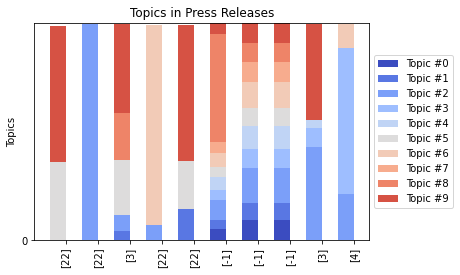

In [37]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

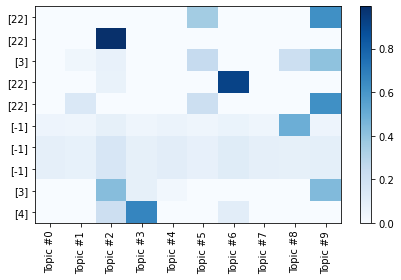

In [38]:
#visualize as a heat map
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [39]:
#look at which topic has the highest weight
senlda.show_topic(1)

[('be', 0.014603047),
 ('un', 0.003641801),
 ('dat', 0.0031306397),
 ('charta', 0.0026813035),
 ('flüchtlinge', 0.00265031),
 ('türkei', 0.0023694912),
 ('trittin', 0.00212555),
 ('abgelaufen', 0.002110949),
 ('entwicklungszusammenarbeit', 0.002075453),
 ('militärische', 0.0019138717)]

This is very interesting to me. While many of the highest-weighted topics are related to agricultural policy (e.g. "Agrarpolitik", "Landwirte" (-- farmers)), "Osterweiterung" (Eastward expansion" is ranked #6. The German reunification even in 1998, 8 years after it happening, seems to be an important event that is dicusssed in parliament.

In [40]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,be,be,be,be,sammelübersicht,be,be,be,be,be
1,transrapid,un,aufschwung,de,be,transporte,kosovo,agrarpolitik,prävention,umweltpolitik
2,mecklenburg,dat,untersuchungsausschuß,dat,stimmenthaltungen,entwicklungspolitik,kind,bauern,zahnersatz,französischen
3,vorpommern,charta,biedenkopf,krankenkassen,petitionsausschusses,castor,job,landwirte,kind,nächster
4,kind,flüchtlinge,pflegeversicherung,kind,petitionen,gegenstimmen,jugoslawien,ns,ärzte,regierungssprecher
5,akten,türkei,enquete,goethe,gegenstimmen,enquete,milosevic,petitionen,öpnv,bgs
6,schiene,trittin,rotgrün,kulturpolitik,joachim,diktatur,bafög,amsterdam,gesundheitspolitik,ländlichen
7,verkehrspolitik,abgelaufen,vermögensteuer,patienten,unterrichtung,atomenergie,petitionsausschuß,raumordnung,wohnung,streitkräfte
8,brenner,entwicklungszusammenarbeit,wählerinnen,mieter,heinz,kernenergie,osze,städtebau,verbrechen,krisen
9,hast,militärische,riester,abgedruckt,buchstabe,entschuldigung,osterweiterung,übereinkommen,unterlagen,amerikanischen


<Figure size 432x288 with 0 Axes>

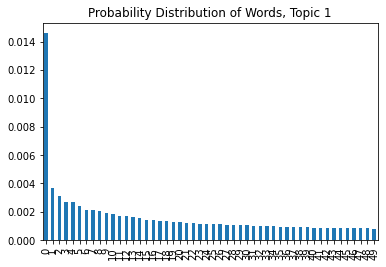

In [41]:
#make a visualization of the distribution of words
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [42]:
#how do different n values change the distribution?
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:807: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


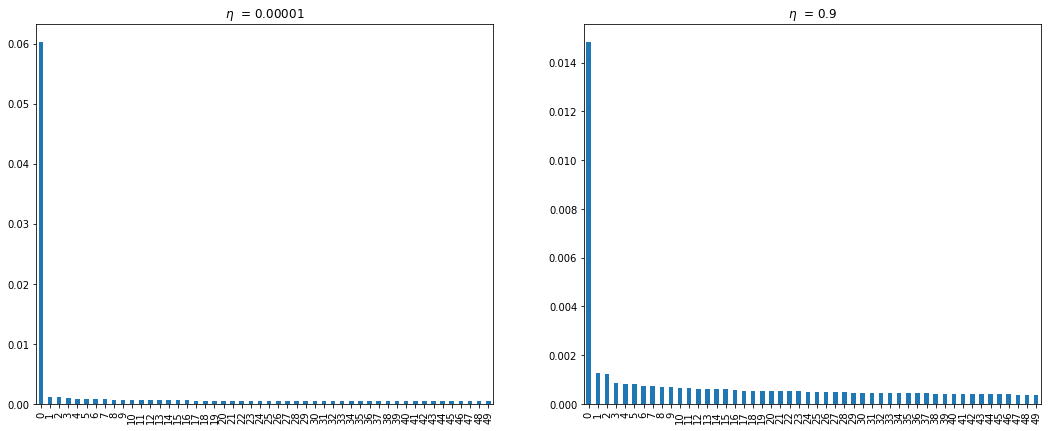

In [43]:
#visualize the different kinds of visualizations based on higher/lower n values
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

In [44]:
#Hierarchical Dirichlet Process
from gensim.models import HdpModel
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.print_topics()

[(0,
  '0.040*be + 0.001*kind + 0.001*kosovo + 0.001*pflegeversicherung + 0.001*enquete + 0.001*gestalt + 0.000*umweltpolitik + 0.000*pflege + 0.000*welch + 0.000*bundesbank'),
 (1,
  '0.009*be + 0.005*sammelübersicht + 0.005*stimmenthaltungen + 0.005*joachim + 0.005*heinz + 0.004*bernd + 0.004*gegenstimmen + 0.003*zustimmt + 0.003*georg + 0.003*winfried'),
 (2,
  '0.026*be + 0.001*entwicklungspolitik + 0.001*mehrwertsteuer + 0.001*mädchen + 0.001*oskar + 0.001*beschneidung + 0.001*verbraucher + 0.001*bauwirtschaft + 0.001*saarland + 0.001*genitalverstümmelung'),
 (3,
  '0.017*be + 0.002*türkei + 0.002*kind + 0.001*mädchen + 0.001*beschneidung + 0.001*flüchtlinge + 0.001*quote + 0.001*wohnung + 0.001*tschechischen + 0.001*verstümmelung'),
 (4,
  '0.013*be + 0.001*wahlkreise + 0.001*einzelplan + 0.001*kuren + 0.001*räume + 0.001*ländlichen + 0.001*energien + 0.001*kfz + 0.000*wahlrecht + 0.000*mörder'),
 (5,
  '0.012*be + 0.001*osterweiterung + 0.001*dreßler + 0.001*studiengebühren + 0.

In [45]:
hdptexts = hdpmodel[corpus]
hdptexts[0]

[(23, 0.9932073653915431)]

For the final project, I'm interested in those speeches dealing with the "New Länder", i.e. the areas of the former GDR and how they're being incorporated into the newly reunified Germany. After topic modeling the corpus, one can see that "Osterweiterung" (east-ward expansion) is a major theme throughout this corpus, in addition to agricultural policy and the Balkan civil wars. I find it interesting to see the different ways of grouping together texts from the corpus. While in exercise 1, the k-means clusters didn't really provide meaningful insights due to a lack of pre-cleaning of the dataset, this fundamentally changed here! 

I also found it interesting to see the different ways of grouping that LDA topic modeling and the hierarchical Dirichlet process revealed. The "Osterweiterung" seems to be a major topic in LDA, whereas it's almost completely absent from the dirichlet analysis. In dirichlet, we see some  of the same prevalent themes (e.g. the Balkans), but also some less meaningful topics. For example, the dirichlet process revealed the following list of words as a topic: "Joachim", "Heinz", "Bernd", "Georg", "Günther", "Renate", "Erika", "Winfried" -- all of which are simply first names.



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [47]:
#normalize and tokenize
real_df = smalldf[['speechContent', 'factionId', 'lastName']]
real_df = real_df.reset_index()
real_df['tokenized_text'] = real_df['speechContent'].apply(lambda x: lucem_illud.word_tokenize(x))
real_df['normalized_tokens'] = real_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [48]:
#Dynamic Topic Modeling
#create appropriate corpus -- call from original dataframe, keep speechContent, factionId, and year variable
corpus = smalldf[['speechContent', 'factionId', 'date']]
coha_texts = corpus['speechContent']
coha_genres = {}
coha_years = {}

In [49]:
#create loop around speeches & years? not sure how exactly to approach this
for speechContent in coha_texts
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])

SyntaxError: ignored

In [ ]:
import collections
years = []
year_lens = []
for year_info in collections.OrderedDict(sorted(corpus['date'].items())):
    years.append(year_info)
    year_lens.append(len((corpus['date'][year_info])))
years[0], years[-1]

TypeError: ignored

I'm sorry, I don't know how to approach this question. I'm sure the dynamic approach would have resulted in different modeled topics, but alas, I was unable to produce such results. In the future, I think I would greatly benefit if we went over the homework sets more in class; as it is right now, the homework sets feel rather disjointed from the theoretical concepts we learn in class (or at least for me, as someone with limited experience in programming, I don't really feel like I'm learning much from doing this).